In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [87]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [88]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [89]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [90]:
from scipy.optimize import minimize

### Ansatz State

In [91]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [92]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [93]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [94]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [95]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [96]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [97]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [98]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [99]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [100]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [101]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [102]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [103]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [104]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [105]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [106]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [107]:
approximated_energies = []

In [108]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [109]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [110]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [111]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [112]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:03,  8.15it/s]
27it [00:03,  7.60it/s]
27it [00:03,  8.28it/s]
27it [00:02, 11.18it/s]
27it [00:02, 12.91it/s]
27it [00:02, 12.72it/s]
27it [00:02, 13.03it/s]
27it [00:02, 13.16it/s]
27it [00:02, 13.35it/s]
27it [00:02, 13.35it/s]
27it [00:02, 12.19it/s]
27it [00:02, 12.35it/s]
27it [00:02, 12.12it/s]
27it [00:02, 11.78it/s]
27it [00:02, 11.83it/s]
27it [00:02, 13.33it/s]
27it [00:02, 12.08it/s]
27it [00:02, 12.57it/s]
27it [00:02, 11.16it/s]
27it [00:02, 11.36it/s]
27it [00:02, 11.27it/s]
27it [00:02, 11.57it/s]
27it [00:02, 11.35it/s]
27it [00:02, 12.84it/s]
27it [00:02, 12.69it/s]
27it [00:02,  9.14it/s]
27it [00:02, 10.32it/s]
27it [00:02, 11.80it/s]
27it [00:02, 11.31it/s]
27it [00:02, 11.43it/s]
27it [00:02, 11.18it/s]
27it [00:02, 11.12it/s]
27it [00:02, 10.84it/s]
27it [00:02, 10.96it/s]
27it [00:02, 10.74it/s]
27it [00:02, 10.83it/s]
27it [00:02, 11.06it/s]
27it [00:02, 10.47it/s]
27it [00:02,  9.53it/s]
27it [00:02, 10.46it/s]
27it [00:02, 10.62it/s]
27it [00:02, 10.

[1.54993039 2.75757577 1.54434536 1.7691483  1.77388153 4.41657264
 3.91259237 1.73700655 2.81575438 6.57617108 5.28323861 1.29989703
 2.88418809 2.49668664 0.20991738 3.36212539 1.79952894 3.04566069
 4.79819162 3.8615294  2.94369335 0.89687486 2.49875089 1.10527608
 2.05204109 6.22733099 1.8374727  2.86357379 0.24515511 2.25182231
 3.81033978 5.52166644]


27it [00:02, 12.44it/s]

CPU times: total: 2min 2s
Wall time: 2min 4s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.6968858397037545

Approximation Error
0.0210978136955869


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


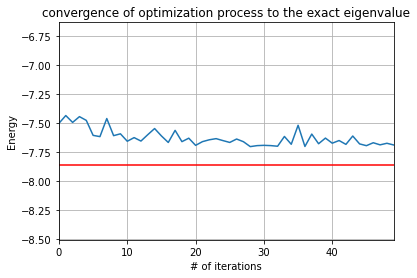

In [113]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [114]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:03,  8.04it/s]
27it [00:03,  8.70it/s]
27it [00:03,  8.71it/s]
27it [00:03,  8.55it/s]
27it [00:02,  9.55it/s]
27it [00:02, 10.50it/s]
27it [00:02, 11.07it/s]
27it [00:02, 11.24it/s]
27it [00:03,  8.76it/s]
27it [00:03,  8.48it/s]
27it [00:03,  8.50it/s]
27it [00:03,  8.90it/s]
27it [00:03,  8.96it/s]
27it [00:03,  8.64it/s]
27it [00:02, 10.70it/s]
27it [00:02, 13.07it/s]
27it [00:02, 12.47it/s]
27it [00:02, 11.62it/s]
27it [00:02, 12.36it/s]
27it [00:02, 10.45it/s]
27it [00:02,  9.81it/s]
27it [00:02, 11.79it/s]
27it [00:02, 12.54it/s]
27it [00:02, 11.99it/s]
27it [00:02, 12.78it/s]
27it [00:02, 12.67it/s]
27it [00:02, 12.38it/s]
27it [00:02, 11.97it/s]
27it [00:02, 11.61it/s]
27it [00:01, 13.68it/s]
27it [00:02, 11.87it/s]
27it [00:02, 11.44it/s]
27it [00:02, 10.56it/s]
27it [00:02, 11.86it/s]
27it [00:02, 12.15it/s]
27it [00:01, 13.89it/s]
27it [00:02, 11.93it/s]
27it [00:02, 12.82it/s]
27it [00:01, 13.52it/s]
27it [00:01, 14.07it/s]
27it [00:02, 13.11it/s]
27it [00:01, 13.

[0.95358354 3.54073699 2.94332375 5.07450833 4.96858932 3.23334616
 4.56885102 6.19002993 1.40554457 0.76182747 4.48539242 6.18716626
 4.2535408  1.21116965 5.40454388 6.05295221 4.66735654 5.55932715
 2.53300143 0.10759828 3.82450467 5.85661074 6.05789809 3.57100269
 5.47113901 0.05907055 3.22155267 5.66210036 3.296033   4.75552997
 5.78802693 3.1560735 ]


27it [00:02, 13.14it/s]

CPU times: total: 1min 59s
Wall time: 2min 2s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.689212962110365

Approximation Error
0.022073662474929603


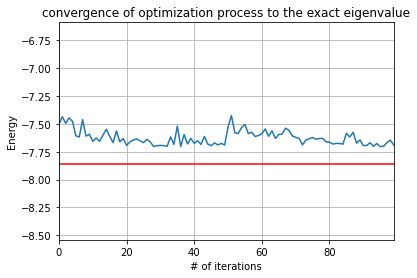

In [115]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [116]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [117]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01, 11.51it/s]
15it [00:01, 14.36it/s]
15it [00:01, 12.88it/s]
15it [00:01, 14.12it/s]
15it [00:01, 14.83it/s]
15it [00:00, 15.37it/s]
15it [00:01, 13.15it/s]
15it [00:00, 15.11it/s]
15it [00:01, 14.73it/s]
15it [00:01, 11.79it/s]
15it [00:01, 14.60it/s]
15it [00:01, 13.19it/s]
15it [00:01, 14.11it/s]
15it [00:01, 13.41it/s]
15it [00:01, 13.33it/s]
15it [00:01, 14.27it/s]
15it [00:01, 12.95it/s]
15it [00:01, 13.17it/s]
15it [00:01, 13.84it/s]
15it [00:01, 13.86it/s]
15it [00:01, 13.00it/s]
15it [00:01, 13.79it/s]
15it [00:01, 13.40it/s]
15it [00:01, 13.34it/s]
15it [00:01, 13.18it/s]
15it [00:01, 12.66it/s]
15it [00:01, 12.14it/s]
15it [00:01, 12.43it/s]
15it [00:01, 12.35it/s]
15it [00:01, 12.73it/s]
15it [00:01, 14.67it/s]
15it [00:01, 14.54it/s]
15it [00:01, 13.05it/s]
15it [00:01, 12.70it/s]
15it [00:01, 13.11it/s]
15it [00:01, 12.64it/s]
15it [00:01, 13.66it/s]
15it [00:01, 12.61it/s]
15it [00:01, 13.02it/s]
15it [00:01, 13.05it/s]
15it [00:01, 13.20it/s]
15it [00:01, 14.

[6.73179147 5.99411673 4.50427654 5.45879066 2.95320046 1.27623428
 1.0765997  2.46000126 1.829515   1.94824281 6.02242558 0.17710852
 1.13320639 4.04119036 3.57155068 4.49636946 6.90443069 1.09426097
 0.86378989 3.92583729 6.40579112 0.97398204 2.59032954 4.21005536
 4.09712954 5.8414712  5.18699716 2.16686497 0.6980917  3.23935322
 2.97713494 3.96127263]


15it [00:01, 13.55it/s]

CPU times: total: 57 s
Wall time: 57.7 s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.0628229432143839

Approximation Error
0.42775144987623476


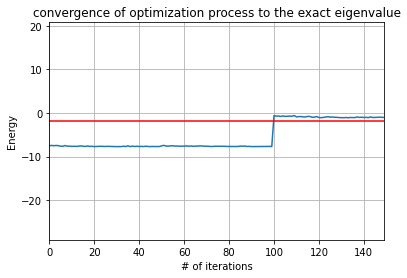

In [118]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [119]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01, 13.16it/s]
15it [00:01, 13.11it/s]
15it [00:01, 12.45it/s]
15it [00:01, 12.93it/s]
15it [00:01, 12.49it/s]
15it [00:01, 14.02it/s]
15it [00:01, 13.50it/s]
15it [00:01, 13.37it/s]
15it [00:01, 11.97it/s]
15it [00:01, 12.86it/s]
15it [00:01, 12.66it/s]
15it [00:01, 11.60it/s]
15it [00:01, 10.11it/s]
15it [00:01, 10.66it/s]
15it [00:01, 10.26it/s]
15it [00:01, 11.75it/s]
15it [00:01, 10.89it/s]
15it [00:01, 10.07it/s]
15it [00:01, 11.85it/s]
15it [00:01, 10.85it/s]
15it [00:01, 10.62it/s]
15it [00:01, 10.93it/s]
15it [00:01, 12.51it/s]
15it [00:01, 11.44it/s]
15it [00:01, 10.88it/s]
15it [00:01, 10.74it/s]
15it [00:01, 11.37it/s]
15it [00:01, 12.89it/s]
15it [00:01, 10.25it/s]
15it [00:01, 10.40it/s]
15it [00:01, 11.09it/s]
15it [00:01, 10.45it/s]
15it [00:01, 10.17it/s]
15it [00:01, 10.82it/s]
15it [00:01, 10.77it/s]
15it [00:01, 11.06it/s]
15it [00:01, 10.30it/s]
15it [00:01, 11.79it/s]
15it [00:01,  7.64it/s]
15it [00:01,  8.17it/s]
15it [00:01,  9.48it/s]
15it [00:01,  9.

[ 0.01104518  6.5590253   1.06681397  5.33177738  4.5155091   4.92331727
 -0.26571036  3.25480837  5.17705642  6.44030464  0.05561605  3.75536082
  6.06372948  0.91339613 -0.37356743  1.22618403  3.63965241  2.46726245
  1.35282805  4.94355573  3.90535474  5.57030353  5.42322345  4.29381436
  2.7780917   3.39751024  0.76516649  5.52770455  1.23416546  7.03560011
  0.75656803  2.19580948]


15it [00:02,  7.27it/s]

CPU times: total: 1min 11s
Wall time: 1min 12s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.3471429187829658

Approximation Error
0.27466697345509816


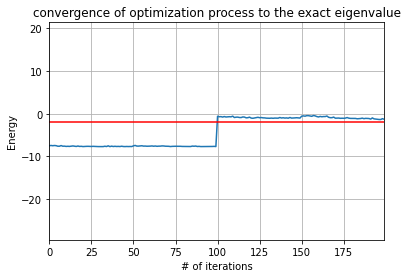

In [120]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [121]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [122]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01,  8.10it/s]
11it [00:01,  7.80it/s]
11it [00:01,  7.75it/s]
11it [00:01,  7.98it/s]
11it [00:01,  8.31it/s]
11it [00:01,  6.99it/s]
11it [00:01,  6.56it/s]
11it [00:01,  7.70it/s]
11it [00:01,  8.21it/s]
11it [00:01,  7.24it/s]
11it [00:01,  7.65it/s]
11it [00:01,  7.74it/s]
11it [00:01,  7.80it/s]
11it [00:01,  7.47it/s]
11it [00:01,  7.52it/s]
11it [00:01,  8.10it/s]
11it [00:01,  7.76it/s]
11it [00:01,  7.43it/s]
11it [00:01,  7.55it/s]
11it [00:01,  7.88it/s]
11it [00:01,  8.16it/s]
11it [00:01,  7.83it/s]
11it [00:01,  7.06it/s]
11it [00:01,  7.70it/s]
11it [00:01,  7.82it/s]
11it [00:01,  7.86it/s]
11it [00:01,  7.86it/s]
11it [00:01,  8.21it/s]
11it [00:01,  7.95it/s]
11it [00:01,  7.53it/s]
11it [00:01,  8.40it/s]
11it [00:01,  7.83it/s]
11it [00:01,  7.45it/s]
11it [00:01,  6.95it/s]
11it [00:01,  8.25it/s]
11it [00:01,  8.34it/s]
11it [00:01,  7.71it/s]
11it [00:01,  7.89it/s]
11it [00:01,  7.41it/s]
11it [00:01,  8.00it/s]
11it [00:01,  8.05it/s]
11it [00:01,  7.

[6.14679156 6.60611737 6.20822194 0.29900035 7.63929907 2.38985237
 6.96812454 3.33184501 6.68639879 4.76503013 5.22950295 1.88023541
 3.68876263 5.30843095 0.83522611 1.78747417 1.88772821 4.95572773
 2.19784126 5.08934905 1.17510071 0.64856312 5.10831734 5.69978714
 0.8378983  5.62309596 5.75150787 2.44858586 3.1481391  2.64265372
 3.54607536 3.2799178 ]


11it [00:01,  7.57it/s]

CPU times: total: 1min 12s
Wall time: 1min 12s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
1.363487519790195

Approximation Error
0.318080843690085


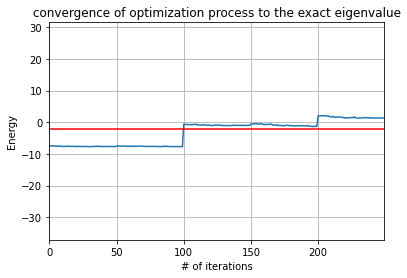

In [123]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [124]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  7.86it/s]
11it [00:01,  7.60it/s]
11it [00:01,  8.29it/s]
11it [00:01,  8.07it/s]
11it [00:01,  7.84it/s]
11it [00:01,  8.17it/s]
11it [00:01,  7.97it/s]
11it [00:01,  7.56it/s]
11it [00:01,  7.53it/s]
11it [00:01,  7.96it/s]
11it [00:01,  7.85it/s]
11it [00:01,  7.18it/s]
11it [00:01,  8.03it/s]
11it [00:01,  7.65it/s]
11it [00:01,  8.08it/s]
11it [00:01,  7.75it/s]
11it [00:01,  7.47it/s]
11it [00:01,  7.52it/s]
11it [00:01,  7.66it/s]
11it [00:01,  8.20it/s]
11it [00:01,  7.85it/s]
11it [00:01,  8.21it/s]
11it [00:01,  7.18it/s]
11it [00:01,  7.25it/s]
11it [00:01,  7.09it/s]
11it [00:01,  8.17it/s]
11it [00:01,  7.44it/s]
11it [00:01,  8.25it/s]
11it [00:01,  7.55it/s]
11it [00:01,  7.92it/s]
11it [00:01,  7.13it/s]
11it [00:01,  8.26it/s]
11it [00:01,  7.44it/s]
11it [00:01,  7.73it/s]
11it [00:01,  7.38it/s]
11it [00:01,  6.91it/s]
11it [00:01,  7.25it/s]
11it [00:01,  6.92it/s]
11it [00:01,  6.98it/s]
11it [00:01,  7.87it/s]
11it [00:01,  8.55it/s]
11it [00:01,  7.

[5.45764734 3.92869664 3.9147481  4.82458239 5.27852215 1.37147886
 1.30516191 5.6659611  1.42005284 4.44582499 5.24233928 3.64781194
 2.47516246 3.08932653 5.22317468 1.12755036 3.99695712 5.16486278
 0.36586908 0.73210627 6.11128127 4.17515521 4.707102   2.33456157
 5.52467448 1.16509372 0.67058406 3.75873385 4.81634677 2.8319784
 1.06859126 1.08891463]


11it [00:01,  7.24it/s]

CPU times: total: 1min 13s
Wall time: 1min 13s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
1.3963937226287835

Approximation Error
0.30162350928008175


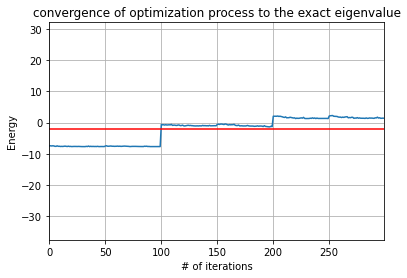

In [125]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [126]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [127]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [128]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00, 10.32it/s]
7it [00:00, 10.45it/s]
7it [00:00, 11.29it/s]
7it [00:00, 12.24it/s]
7it [00:00, 12.38it/s]
7it [00:00, 14.72it/s]
7it [00:00, 17.58it/s]
7it [00:00, 15.37it/s]
7it [00:00, 15.57it/s]
7it [00:00, 14.14it/s]
7it [00:00, 15.23it/s]
7it [00:00, 15.69it/s]
7it [00:00, 16.79it/s]
7it [00:00, 16.79it/s]
7it [00:00, 16.74it/s]
7it [00:00, 15.73it/s]
7it [00:00, 15.54it/s]
7it [00:00, 15.75it/s]
7it [00:00, 15.69it/s]
7it [00:00, 15.52it/s]
7it [00:00, 16.79it/s]
7it [00:00, 15.54it/s]
7it [00:00, 16.82it/s]
7it [00:00, 17.57it/s]
7it [00:00, 13.70it/s]
7it [00:00, 13.41it/s]
7it [00:00, 16.68it/s]
7it [00:00, 15.47it/s]
7it [00:00, 16.26it/s]
7it [00:00, 14.94it/s]
7it [00:00, 17.26it/s]
7it [00:00, 15.89it/s]
7it [00:00, 10.50it/s]
7it [00:00,  7.74it/s]
7it [00:00, 10.57it/s]
7it [00:00, 10.99it/s]
7it [00:00, 12.28it/s]
7it [00:00, 14.49it/s]
7it [00:00, 14.68it/s]
7it [00:00, 13.98it/s]
7it [00:00, 13.24it/s]
7it [00:00, 15.93it/s]
7it [00:00, 13.28it/s]
7it [00:00,

[6.27867518 7.13521545 3.41045016 1.68491202 6.55674548 4.86164483
 3.17072405 5.52849296 1.05761609 3.83394171 0.56214461 5.01092989
 2.18648256 1.46199247 0.68327138 6.89624227 5.48014974 2.28022979
 5.75499557 2.70478786 0.86695008 3.81385907 2.86969792 2.32950402]


7it [00:00, 14.11it/s]

CPU times: total: 24.9 s
Wall time: 25.3 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.4617558613792809

Approximation Error
0.5923442212893069


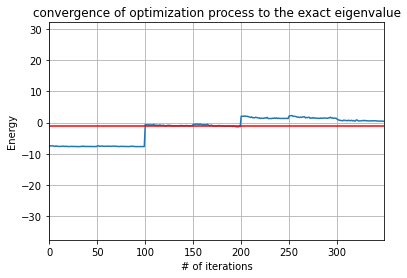

In [129]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [130]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 14.96it/s]
7it [00:00, 14.34it/s]
7it [00:00, 15.05it/s]
7it [00:00, 14.11it/s]
7it [00:00, 14.42it/s]
7it [00:00, 15.26it/s]
7it [00:00, 16.31it/s]
7it [00:00, 13.62it/s]
7it [00:00, 15.06it/s]
7it [00:00, 14.39it/s]
7it [00:00, 15.71it/s]
7it [00:00, 16.85it/s]
7it [00:00, 17.93it/s]
7it [00:00, 14.25it/s]
7it [00:00, 14.88it/s]
7it [00:00, 12.88it/s]
7it [00:00, 13.98it/s]
7it [00:00, 15.97it/s]
7it [00:00, 14.42it/s]
7it [00:00, 15.54it/s]
7it [00:00, 16.87it/s]
7it [00:00, 17.69it/s]
7it [00:00, 18.76it/s]
7it [00:00, 16.20it/s]
7it [00:00, 16.10it/s]
7it [00:00, 15.61it/s]
7it [00:00, 17.90it/s]
7it [00:00, 15.35it/s]
7it [00:00, 16.93it/s]
7it [00:00, 16.17it/s]
7it [00:00, 14.65it/s]
7it [00:00, 16.58it/s]
7it [00:00, 16.48it/s]
7it [00:00, 16.45it/s]
7it [00:00, 14.76it/s]
7it [00:00, 16.24it/s]
7it [00:00, 14.98it/s]
7it [00:00, 18.33it/s]
7it [00:00, 14.20it/s]
7it [00:00, 15.31it/s]
7it [00:00, 16.00it/s]
7it [00:00, 16.25it/s]
7it [00:00, 17.78it/s]
7it [00:00,

[7.05124417 3.66911965 1.6689297  6.96244127 2.9889638  5.76232109
 5.79257004 6.33162089 4.39207414 5.90274696 4.98309213 1.50518551
 2.85249474 7.48803346 0.60899192 3.63789588 1.69050738 5.43017356
 1.52340604 2.395211   1.27962922 4.04559031 2.60774703 2.92762093]


7it [00:00, 15.30it/s]

CPU times: total: 23.2 s
Wall time: 23.5 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.4505828701007238

Approximation Error
0.6022081663761821


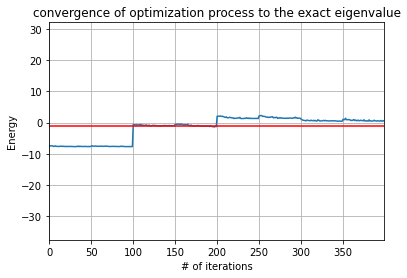

In [131]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [132]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [133]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [134]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 26.19it/s]
3it [00:00, 23.80it/s]
3it [00:00, 23.40it/s]
3it [00:00, 18.68it/s]
3it [00:00, 20.27it/s]
3it [00:00, 19.82it/s]
3it [00:00, 19.80it/s]
3it [00:00, 21.55it/s]
3it [00:00, 18.80it/s]
3it [00:00, 20.24it/s]
3it [00:00, 21.91it/s]
3it [00:00, 23.03it/s]
3it [00:00, 22.04it/s]
3it [00:00, 24.15it/s]
3it [00:00, 21.48it/s]
3it [00:00, 23.40it/s]
3it [00:00, 23.55it/s]
3it [00:00, 20.55it/s]
3it [00:00, 18.25it/s]
3it [00:00, 25.29it/s]
3it [00:00, 19.16it/s]
3it [00:00, 16.37it/s]
3it [00:00, 21.04it/s]
3it [00:00, 16.51it/s]
3it [00:00, 18.75it/s]
3it [00:00, 17.25it/s]
3it [00:00, 18.94it/s]
3it [00:00, 19.62it/s]
3it [00:00, 16.50it/s]
3it [00:00, 16.09it/s]
3it [00:00, 15.09it/s]
3it [00:00, 19.64it/s]
3it [00:00, 19.53it/s]
3it [00:00, 23.63it/s]
3it [00:00, 14.90it/s]
3it [00:00, 19.36it/s]
3it [00:00, 15.32it/s]
3it [00:00, 20.23it/s]
3it [00:00, 17.34it/s]
3it [00:00, 19.37it/s]
3it [00:00, 13.30it/s]
3it [00:00, 18.30it/s]
3it [00:00, 19.97it/s]
3it [00:00,

[3.10026433 6.34564448 5.94987256 0.58473363 3.94774964 2.4437429
 3.79901406 2.43717207 2.38350708 2.87373267 5.16107543 1.14708119
 5.7605024  5.75473097 2.31022897 2.36211669]


3it [00:00, 23.01it/s]

CPU times: total: 7.98 s
Wall time: 8.18 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.278242839751331

Approximation Error
0.729065485700943


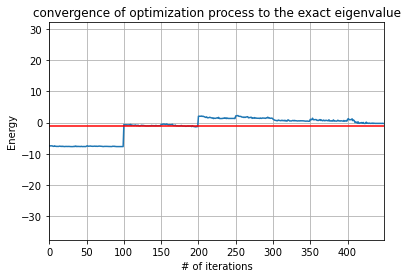

In [135]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [136]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 13.94it/s]
3it [00:00, 14.49it/s]
3it [00:00, 17.30it/s]
3it [00:00, 17.76it/s]
3it [00:00, 22.04it/s]
3it [00:00, 21.51it/s]
3it [00:00, 21.80it/s]
3it [00:00, 19.40it/s]
3it [00:00, 15.12it/s]
3it [00:00, 18.09it/s]
3it [00:00, 21.72it/s]
3it [00:00, 17.21it/s]
3it [00:00, 17.46it/s]
3it [00:00, 18.82it/s]
3it [00:00, 17.82it/s]
3it [00:00, 18.34it/s]
3it [00:00, 21.04it/s]
3it [00:00, 19.73it/s]
3it [00:00, 20.88it/s]
3it [00:00, 17.59it/s]
3it [00:00, 18.67it/s]
3it [00:00, 15.22it/s]
3it [00:00, 18.81it/s]
3it [00:00, 18.00it/s]
3it [00:00, 21.39it/s]
3it [00:00, 17.81it/s]
3it [00:00, 18.10it/s]
3it [00:00, 16.75it/s]
3it [00:00, 17.76it/s]
3it [00:00, 19.48it/s]
3it [00:00, 18.69it/s]
3it [00:00, 16.23it/s]
3it [00:00, 14.76it/s]
3it [00:00, 22.03it/s]
3it [00:00, 22.48it/s]
3it [00:00, 17.94it/s]
3it [00:00, 18.38it/s]
3it [00:00, 19.11it/s]
3it [00:00, 16.47it/s]
3it [00:00, 16.99it/s]
3it [00:00, 12.66it/s]
3it [00:00, 14.62it/s]
3it [00:00, 12.26it/s]
3it [00:00,

[3.47061435 1.62459206 2.12578575 4.7908193  4.35583866 4.01537722
 4.73449044 0.65882463 5.89819788 6.94605128 6.5822974  1.69032423
 2.79085843 0.71732611 3.36355222 4.03517492]


3it [00:00, 15.13it/s]

CPU times: total: 9.27 s
Wall time: 9.36 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.2832459242878529

Approximation Error
0.7241938121652964


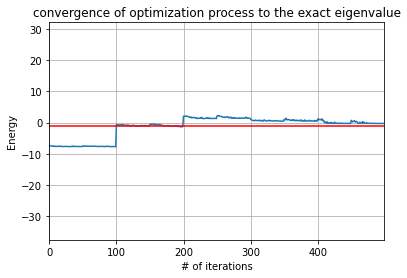

In [137]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [138]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [139]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 10.77it/s]
4it [00:00, 10.43it/s]
4it [00:00, 10.02it/s]
4it [00:00,  8.33it/s]
4it [00:00,  9.02it/s]
4it [00:00, 13.07it/s]
4it [00:00, 10.92it/s]
4it [00:00, 10.42it/s]
4it [00:00, 12.70it/s]
4it [00:00, 11.14it/s]
4it [00:00, 15.65it/s]
4it [00:00, 12.58it/s]
4it [00:00, 13.88it/s]
4it [00:00, 15.40it/s]
4it [00:00, 12.47it/s]
4it [00:00, 12.78it/s]
4it [00:00, 12.60it/s]
4it [00:00, 11.65it/s]
4it [00:00, 12.36it/s]
4it [00:00,  9.82it/s]
4it [00:00, 13.06it/s]
4it [00:00, 12.80it/s]
4it [00:00, 10.63it/s]
4it [00:00, 11.98it/s]
4it [00:00, 11.56it/s]
4it [00:00, 15.00it/s]
4it [00:00, 12.25it/s]
4it [00:00, 12.86it/s]
4it [00:00, 11.42it/s]
4it [00:00, 12.32it/s]
4it [00:00, 12.94it/s]
4it [00:00, 12.88it/s]
4it [00:00, 12.59it/s]
4it [00:00, 13.02it/s]
4it [00:00, 13.08it/s]
4it [00:00, 12.89it/s]
4it [00:00, 12.30it/s]
4it [00:00, 11.05it/s]
4it [00:00, 13.18it/s]
4it [00:00, 12.45it/s]
4it [00:00, 15.01it/s]
4it [00:00, 15.79it/s]
4it [00:00, 10.67it/s]
4it [00:00,

[3.98771774 4.01186436 1.97143596 5.88929056 7.0851045  4.01621193
 4.08199094 3.41939994 0.64300201 1.90806583 0.16891917 3.041478
 4.78205603 1.11474645 3.77621977 2.11850339]


4it [00:00, 11.80it/s]

CPU times: total: 16 s
Wall time: 17.4 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9678839494746276

Approximation Error
0.037033635561042506


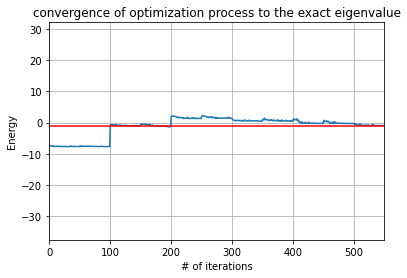

In [140]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [141]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 14.81it/s]
4it [00:00, 13.71it/s]
4it [00:00, 14.59it/s]
4it [00:00, 13.80it/s]
4it [00:00, 20.69it/s]
4it [00:00, 18.63it/s]
4it [00:00, 14.55it/s]
4it [00:00, 21.34it/s]
4it [00:00, 16.84it/s]
4it [00:00, 16.06it/s]
4it [00:00, 17.57it/s]
4it [00:00, 15.11it/s]
4it [00:00, 18.49it/s]
4it [00:00, 15.90it/s]
4it [00:00, 19.11it/s]
4it [00:00, 18.11it/s]
4it [00:00, 15.34it/s]
4it [00:00, 17.48it/s]
4it [00:00, 20.14it/s]
4it [00:00, 18.33it/s]
4it [00:00, 16.90it/s]
4it [00:00, 17.87it/s]
4it [00:00, 17.61it/s]
4it [00:00, 16.08it/s]
4it [00:00, 15.85it/s]
4it [00:00, 15.07it/s]
4it [00:00, 15.32it/s]
4it [00:00, 16.38it/s]
4it [00:00, 19.37it/s]
4it [00:00, 16.76it/s]
4it [00:00, 18.59it/s]
4it [00:00, 23.22it/s]
4it [00:00, 16.59it/s]
4it [00:00, 20.29it/s]
4it [00:00, 16.99it/s]
4it [00:00, 16.94it/s]
4it [00:00, 14.73it/s]
4it [00:00, 14.21it/s]
4it [00:00, 12.34it/s]
4it [00:00, 15.08it/s]
4it [00:00, 13.95it/s]
4it [00:00, 13.27it/s]
4it [00:00, 19.00it/s]
4it [00:00,

[ 4.48115771  4.82613252  3.38911787  4.74768231  5.57645293  4.7661606
 -0.61560509  1.89958438  1.2187858   2.96322615  7.82350239  1.6508413
  2.41946796  5.88761832  4.74572346  1.67275965]


4it [00:00, 16.72it/s]

CPU times: total: 12.4 s
Wall time: 12.7 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9931685412080608

Approximation Error
0.011877508743272942


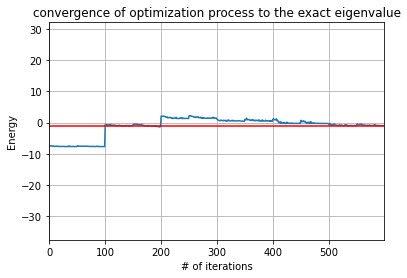

In [142]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)